In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 3.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Environment config

In [3]:
MODE = "colab" # valid modes are 'local', 'colab' and 'kaggle'
SAMPLE_NUMBERS = 4
TEST_PORTION = 0.2

## Model training config

In [4]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 20

SEQUENCE_LEN = 64
CNN_FILTERS = 64
LSTM_HIDDEN_DIM = 196
LSTM_BIDIRECTIONAL = False

## Auto setup

In [5]:
if   MODE == "local":
    BASE_PATH = "."
elif MODE == "colab":
    BASE_PATH = "/content/drive/MyDrive/Deep Neural Network - UT/CA 04"
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print(f"Unknown mode {MODE}")
    exit(1)

Mounted at /content/drive


In [6]:
DATA_PATH = os.path.join(BASE_PATH, "twitter-suicidal_data.csv")

W2V_PATH = os.path.join(BASE_PATH, "w2v_vectors.kv")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data Exploration

## Load Data

In [7]:
df = pd.read_csv(DATA_PATH)

## Data statistics

In [8]:
df.head(5)

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


In [10]:
print(f"Number of samples: {len(df)}")

Number of samples: 9119


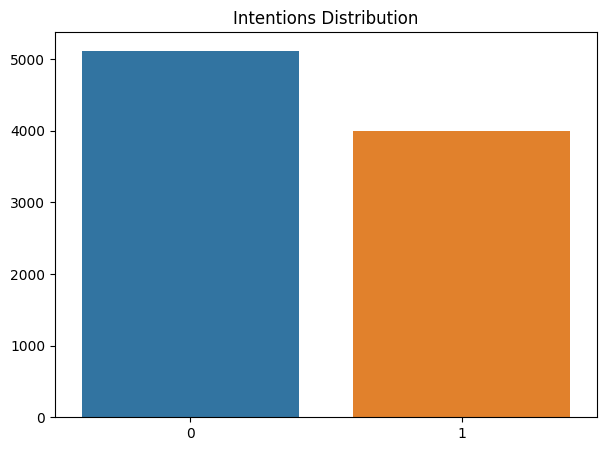

In [11]:
intentions = df["intention"].value_counts()

plt.figure(figsize=(7, 5))
sns.barplot(x=intentions.index, y=intentions.values)
plt.title("Intentions Distribution")
plt.show()

In [12]:
from sklearn.utils import compute_class_weight

labels = df["intention"]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
weights = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)
print(class_weights)
del labels

[0.89035345 1.14044522]


# Data Preprocessing

In [13]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [14]:
def convert_emoji_to_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    0. concatenation of the text (not necessary)
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """
    # text = ''.join(text)
    # lowercase the text
    text = text.lower()
    # remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # remove numbers
    text = re.sub(r"\d+", "", text)
    # remove urls,
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # remove usernames
    text = re.sub(r'@\S+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # convert emojis to text
    text = convert_emoji_to_text(text)
    # remove non-word characters
    text = re.sub(r"[^\w\s]", "", text)
    # lemmatization and tokenization of the text
    tokenized = nltk.word_tokenize(text)
    pos_tag = nltk.pos_tag(tokenized)
    tokens = [
        lemmatizer.lemmatize(token, nltk_pos_tagger(tag))
        for token, tag in pos_tag
    ]
    # remove stopwords
    tokens = [token for token in tokens if token not in stopwords]

    return tokens


In [15]:
def format_length_bound(text: str, length:int):
    if len(text) <= length:
        return text
    mm = length // 2 - 3
    rr = length - mm - 5
    return text[:mm] + "|...|" + text[-rr:]

def draw_sample_processing(dataframe: pd.DataFrame, sample_numbers: int = SAMPLE_NUMBERS, show=True):
    sample_text = dataframe.sample(sample_numbers)
    label_rawT_procT = [
        (label, tweet, preprocess_data(tweet))
        for tweet, label in zip(sample_text["tweet"], sample_text["intention"])
    ]
    if show:
        for idx, (label, rawT, procT) in enumerate(label_rawT_procT, start=1):
            procT = str(procT)
            print(f"Sample {idx}:")
            print(f":::::::Label          : {label}")
            print(f":::::::Raw Tweet      : {format_length_bound(rawT, 50):<50} ({len(rawT)})")
            print(f":::::::Processed Tweet: {format_length_bound(procT, 50):<50} ({len(procT)})")
        return
    return pd.DataFrame(label_rawT_procT, columns=["Intention", "Raw Tweet", "Processed Tweet"])

In [16]:
draw_sample_processing(df, show=True)

Sample 1:
:::::::Label          : 1
:::::::Raw Tweet      : anyone else feel like |...|t so scared of doing it (630)
:::::::Processed Tweet: ['anyone', 'else', 'fe|...|out', 'amjust', 'scar'] (580)
Sample 2:
:::::::Label          : 1
:::::::Raw Tweet      : suicide i want to kill|...| i just know how i feel (980)
:::::::Processed Tweet: ['suicide', 'want', 'k|...|'know', 'know', 'feel'] (851)
Sample 3:
:::::::Label          : 1
:::::::Raw Tweet      : it seems i have two op|...|fe then so why the wait (1088)
:::::::Processed Tweet: ['seem', 'two', 'optio|...| 'end', 'life', 'wait'] (1044)
Sample 4:
:::::::Label          : 0
:::::::Raw Tweet      :  quite the opposite in nyc sadly                   (33)
:::::::Processed Tweet: ['quite', 'opposite', 'nyc', 'sadly']              (37)


# Word2Vec - Word Embedding

In [17]:
# print available word2vec models
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [18]:
if os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Saving Word2Vec model...")
    w2v_model.save(W2V_PATH)


Loading Word2Vec model...


In [19]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

# Dataset

In [20]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, aggregate=True, **kw_args):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.aggregate = aggregate
        self.max_sequence_len = kw_args.get("sequence_len", 64)
        if not aggregate and "sequence_len" not in kw_args:
            print("You Should provide 'sequence_len' to use not aggregate option!")
            print(f":::: Continue with sequence_len = {self.max_sequence_len} !")

        self.vector_size = w2v_model.vector_size
        self.lazy_mode = kw_args.get("lazy", True)

        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if self.lazy_mode:
            vector = self._get_word_vectors(self.dataframe.iloc[idx]["tokens"])
            return vector, self.dataframe.iloc[idx]["intention"]
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        self.dataframe["tokens"] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe["tokens"].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")
        # self.seq_report()

        if not self.aggregate:
            self.dataframe["tokens"] = self.dataframe["tokens"].map(self._pad)

        if not self.lazy_mode:
            self.dataframe["vector"] = self.dataframe["tokens"].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        if not self.aggregate:
            return torch.stack([
                torch.tensor(self.w2v_model[token] if token in self.w2v_model else np.zeros(self.vector_size), dtype=torch.float32)
                for token in tokens
            ])
        wv = np.zeros(self.vector_size)
        vc = 0
        for token in tokens:
            if token in self.w2v_model:
                wv += self.w2v_model[token]
                vc += 1
        wv = torch.tensor(wv / max(vc, 1), dtype=torch.float32)
        return wv

    def _pad(self, tokens: list):
        if len(tokens) >= self.max_sequence_len:
            return tokens[:self.max_sequence_len]
        return tokens + ["<pad>"] * (self.max_sequence_len - len(tokens))

    def seq_report(self):
        length_all = self.dataframe["tokens"].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe["tokens"].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

# Prepare Data

## Split Data into train-valid

In [21]:
train_df, valid_df = train_test_split(df, test_size=TEST_PORTION, random_state=42, stratify=df["intention"])

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

del df
gc.collect()

0

## Create Datasets

In [22]:
train_dataset = Twitter(train_df, w2v_model, aggregate=False, sequence_len=SEQUENCE_LEN)
valid_dataset = Twitter(valid_df, w2v_model, aggregate=False, sequence_len=SEQUENCE_LEN)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


Deleted 0-Len Samples: 22


<ipython-input-20-998fd6045931>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["tokens"] = self.dataframe["tokens"].map(self._pad)


Deleted 0-Len Samples: 9
Train dataset length: 7273
Valid dataset length: 1815


<ipython-input-20-998fd6045931>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["tokens"] = self.dataframe["tokens"].map(self._pad)


In [23]:
train_dataset.seq_report()
print("*----------------------------------*")
valid_dataset.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[13951 
:::::All Valid Tokens:::[ 9615 
:::::Valid Tokens:::[68.92%]
*----------------------------------*
Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[ 6056 
:::::All Valid Tokens:::[ 4754 
:::::Valid Tokens:::[78.5 %]


# Model and Train

## Utils

In [24]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0
    total_samples = 0
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        sample_count = len(inputs)

        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        test_correct = torch.sum(preds == labels).item()
        test_acc += test_correct

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_correct/sample_count, 5),

            )
        total_samples += sample_count

    test_loss = test_loss / len(loader)
    test_acc = test_acc / total_samples

    return test_loss, test_acc


In [25]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device,
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    model.to(device)

    itr = tqdm(train_loader, total=len(train_loader), leave=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        epoch_samples = 0
        for idx, (inputs, labels) in enumerate(itr, start=1):
            epoch_samples += len(inputs)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            epoch_acc += torch.sum(preds == labels).item()

            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(epoch_acc/epoch_samples, 5),
              )

        epoch_loss = epoch_loss / len(train_loader)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc/epoch_samples)

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [26]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [27]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    probabilities = []
    labels = []

    for data, label in tqdm(loader, leave=False, desc="Generate data"):
        data = data.to(device)

        prob = model(data)

        probabilities.append(prob.detach())
        labels.append(label.detach())
    probabilities = torch.cat(probabilities, dim=0)
    _, predicted = torch.max(probabilities.detach(), dim=1)
    labels = torch.cat(labels, dim=0).detach().cpu().squeeze().numpy()
    predicted = predicted.detach().cpu().squeeze().numpy()

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## LSTM

In [28]:
class DetectorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.1, bidirectional=False):
        super(DetectorLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.hidden_bi_dim = 2 if bidirectional else 1
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.hidden_bi_dim * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.hidden_bi_dim * self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Train modes

In [29]:
# Train
lstm_1l_model = DetectorLSTM(
    input_size=EMBEDDING_VECTOR_DIM,
    hidden_size=LSTM_HIDDEN_DIM,
    bidirectional=LSTM_BIDIRECTIONAL,
    num_layers=1,
    num_classes=2,
)

In [30]:
lstm_1l_model_train_history = train_model(
    model=lstm_1l_model,
    batch_size=BATCH_SIZE,
    loss_function=nn.CrossEntropyLoss(weight=weights),
    optimizer=torch.optim.Adam(lstm_1l_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)

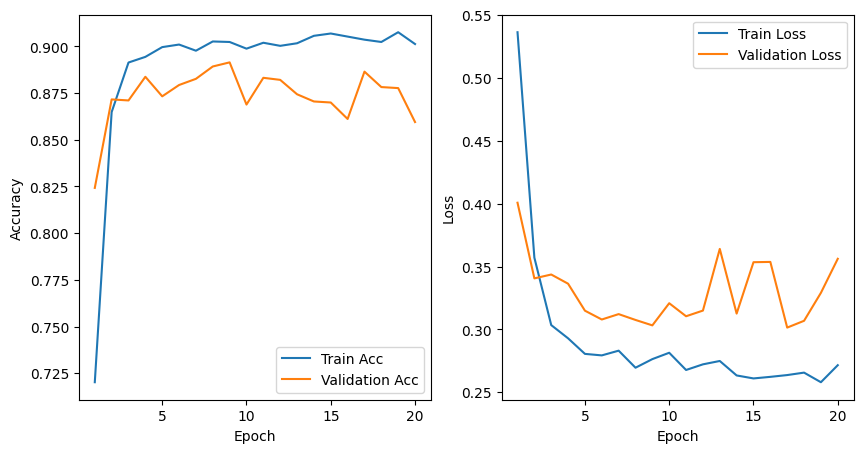

In [31]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", lstm_1l_model_train_history["train_acc"]),
            ("Validation Acc", lstm_1l_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", lstm_1l_model_train_history["train_loss"]),
            ("Validation Loss", lstm_1l_model_train_history["valid_loss"])
        ]
    }
)


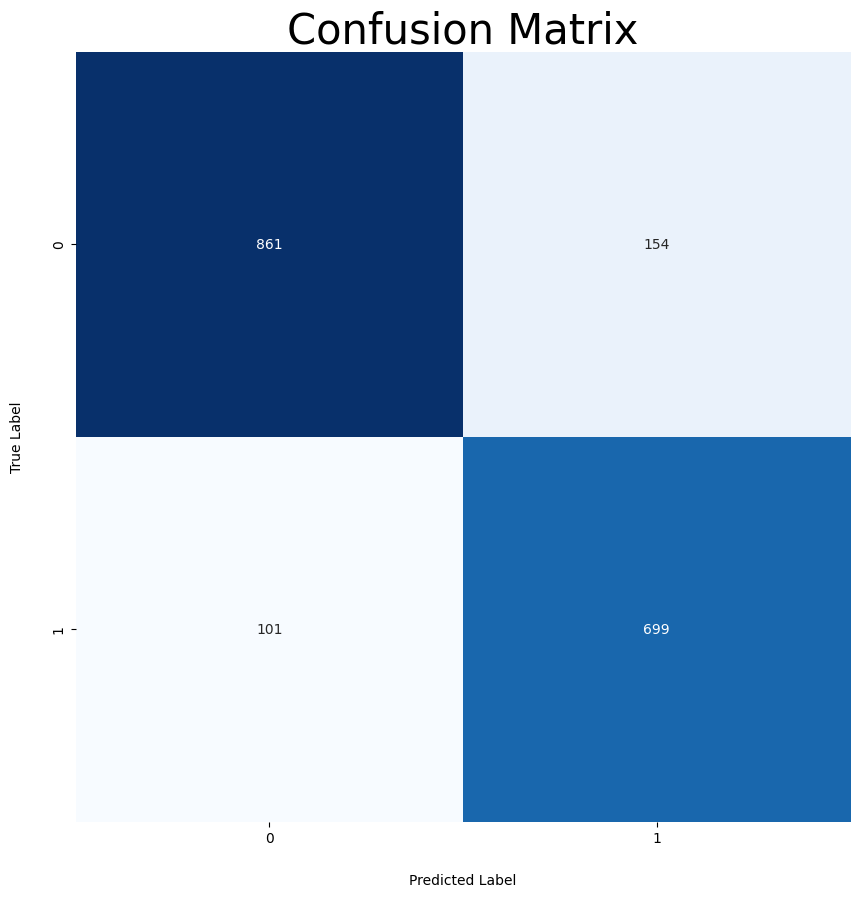

In [32]:
lstm_1l_model_report = generate_confusion_matrix(
    model=lstm_1l_model,
    dataset=valid_dataset,
)

In [33]:
print(f"Recall:    {lstm_1l_model_report['recall']:.3f}")
print(f"F1:        {lstm_1l_model_report['f1']:.3f}")
print(f"Precision: {lstm_1l_model_report['precision']:.3f}")
print(lstm_1l_model_report['report'])

Recall:    0.861
F1:        0.858
Precision: 0.857
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1015
           1       0.82      0.87      0.85       800

    accuracy                           0.86      1815
   macro avg       0.86      0.86      0.86      1815
weighted avg       0.86      0.86      0.86      1815


In [34]:
del lstm_1l_model_train_history, lstm_1l_model, lstm_1l_model_report

if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

9581

## 2-Layer LSTM

In [35]:
lstm_2l_model = DetectorLSTM(
    input_size=EMBEDDING_VECTOR_DIM,
    hidden_size=LSTM_HIDDEN_DIM,
    bidirectional=LSTM_BIDIRECTIONAL,
    num_layers=2,
    num_classes=2
)

In [36]:
lstm_2l_model_train_history = train_model(
    model=lstm_2l_model,
    batch_size=BATCH_SIZE,
    loss_function=nn.CrossEntropyLoss(weight=weights),
    optimizer=torch.optim.Adam(lstm_2l_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)

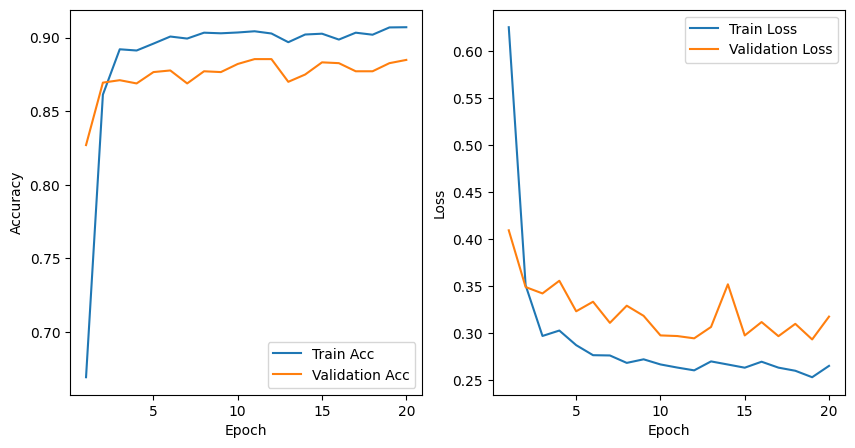

In [37]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", lstm_2l_model_train_history["train_acc"]),
            ("Validation Acc", lstm_2l_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", lstm_2l_model_train_history["train_loss"]),
            ("Validation Loss", lstm_2l_model_train_history["valid_loss"])
        ]
    }
)


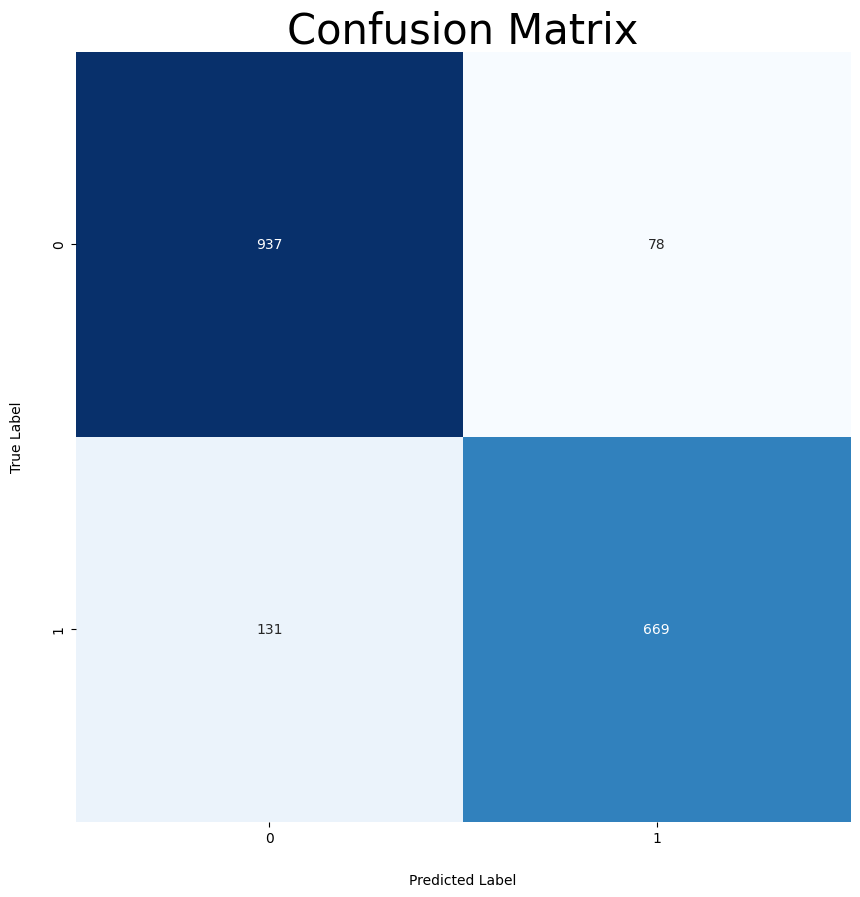

In [38]:
lstm_2l_model_report = generate_confusion_matrix(
    model=lstm_2l_model,
    dataset=valid_dataset,
)

In [39]:
print(f"Recall:    {lstm_2l_model_report['recall']:.3f}")
print(f"F1:        {lstm_2l_model_report['f1']:.3f}")
print(f"Precision: {lstm_2l_model_report['precision']:.3f}")
print(lstm_2l_model_report['report'])

Recall:    0.880
F1:        0.882
Precision: 0.886
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1015
           1       0.90      0.84      0.86       800

    accuracy                           0.88      1815
   macro avg       0.89      0.88      0.88      1815
weighted avg       0.89      0.88      0.88      1815


In [40]:
del lstm_2l_model_train_history, lstm_2l_model, lstm_2l_model_report

if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

9276

## CNN+2-Layer-LSTM

In [41]:
class DetectorCNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, filters, num_lstm_layers, bidirectional, num_classes, dropout=0.1, seq_len=64):
        super(DetectorCNNLSTM, self).__init__()
        self.network = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=filters, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Unflatten(-1, (filters, seq_len//2)),
            DetectorLSTM(
                input_size=seq_len//2,
                hidden_size=hidden_size,
                bidirectional=bidirectional,
                num_layers=num_lstm_layers,
                num_classes=num_classes,
            ),
        )

    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.network(out)
        return out

In [42]:
cnn_lstm_model = DetectorCNNLSTM(
    input_size=EMBEDDING_VECTOR_DIM,
    hidden_size=SEQUENCE_LEN,
    filters=CNN_FILTERS,
    bidirectional=LSTM_BIDIRECTIONAL,
    num_lstm_layers=2,
    num_classes=2,
    dropout=0.5,
    seq_len=SEQUENCE_LEN,
)

In [43]:
cnn_lstm_model_train_history = train_model(
    model=cnn_lstm_model,
    batch_size=BATCH_SIZE,
    loss_function=nn.CrossEntropyLoss(weight=weights),
    optimizer=torch.optim.Adam(cnn_lstm_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)

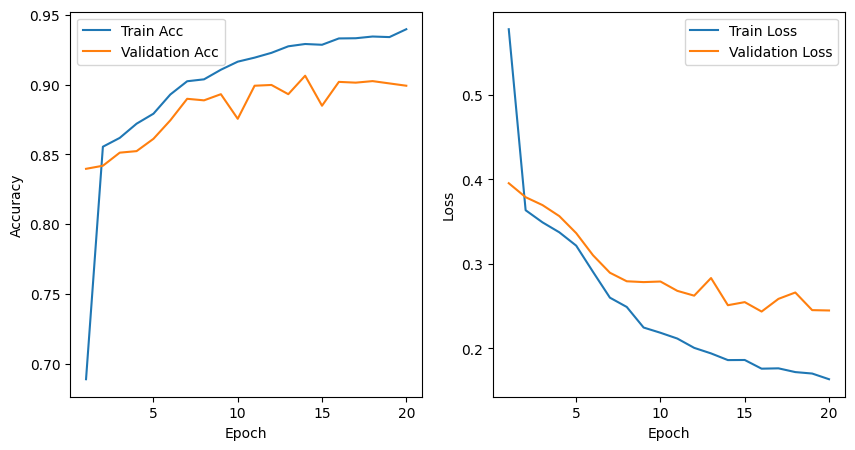

In [44]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_lstm_model_train_history["train_acc"]),
            ("Validation Acc", cnn_lstm_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_lstm_model_train_history["train_loss"]),
            ("Validation Loss", cnn_lstm_model_train_history["valid_loss"])
        ]
    }
)

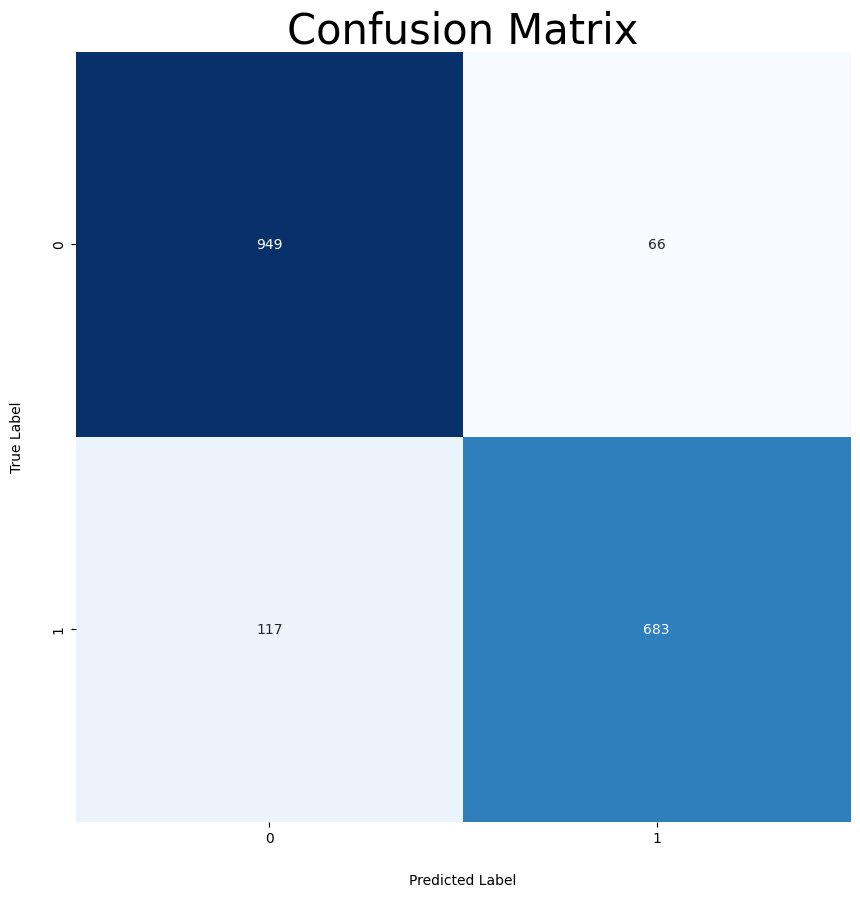

In [45]:
cnn_lstm_model_report = generate_confusion_matrix(
    model=cnn_lstm_model,
    dataset=valid_dataset,
)

In [46]:
print(f"Recall:    {cnn_lstm_model_report['recall']:.3f}")
print(f"F1:        {cnn_lstm_model_report['f1']:.3f}")
print(f"Precision: {cnn_lstm_model_report['precision']:.3f}")
print(cnn_lstm_model_report['report'])

Recall:    0.894
F1:        0.897
Precision: 0.901
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1015
           1       0.91      0.85      0.88       800

    accuracy                           0.90      1815
   macro avg       0.90      0.89      0.90      1815
weighted avg       0.90      0.90      0.90      1815


In [47]:
del cnn_lstm_model_train_history, cnn_lstm_model, cnn_lstm_model_report

if torch.cuda.is_available():
    torch.cuda.empty_cache()